<a href="https://colab.research.google.com/github/swilsonmfc/trees/blob/master/XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# XGBoost

# Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#import catboost as cat
#import lightgbm as lgb
import xgboost  as xgb

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score

from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.classifier import ConfusionMatrix

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


# Boosting - Intuition

![](http://explained.ai/gradient-boosting/images/golf-MSE.png)

# Data

In [2]:
df = pd.read_csv('https://github.com/swilsonmfc/trees/raw/master/mobile.csv')
df

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,6,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,9,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,14,1208,1212,1411,8,2,15,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,794,1,0.5,1,0,1,2,0.8,106,6,14,1222,1890,668,13,4,19,1,1,0,0
1996,1965,1,2.6,1,0,0,39,0.2,187,4,3,915,1965,2032,11,10,16,1,1,1,2
1997,1911,0,0.9,1,1,1,36,0.7,108,8,3,868,1632,3057,9,1,5,1,1,0,3
1998,1512,0,0.9,0,4,1,46,0.1,145,5,5,336,670,869,18,10,19,1,1,1,0


# EDA

## Missing
* No missing data

In [3]:
df.isna().sum()

battery_power    0
blue             0
clock_speed      0
dual_sim         0
fc               0
four_g           0
int_memory       0
m_dep            0
mobile_wt        0
n_cores          0
pc               0
px_height        0
px_width         0
ram              0
sc_h             0
sc_w             0
talk_time        0
three_g          0
touch_screen     0
wifi             0
price_range      0
dtype: int64

## Target
* Multi-Class Problem
* Creator was generous, classes are balanced

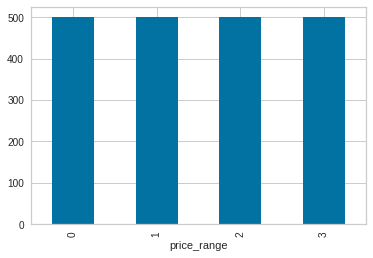

In [4]:
df.groupby('price_range').size().plot.bar();

## Battery

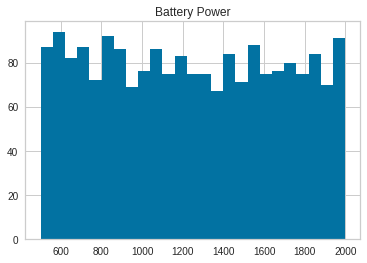

In [5]:
df.battery_power.hist(bins=25)
plt.title('Battery Power');

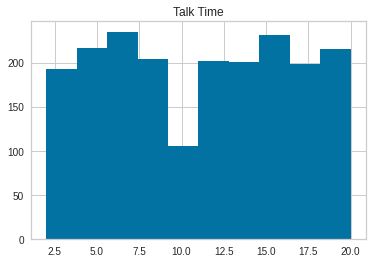

In [6]:
df.talk_time.hist(bins=10)
plt.title('Talk Time');

## Processor

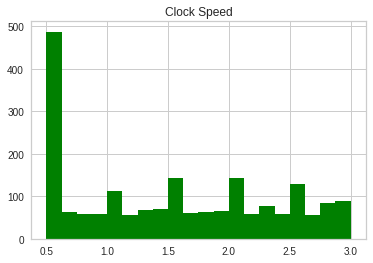

In [7]:
df.clock_speed.hist(bins=20, color='green');
plt.title('Clock Speed');

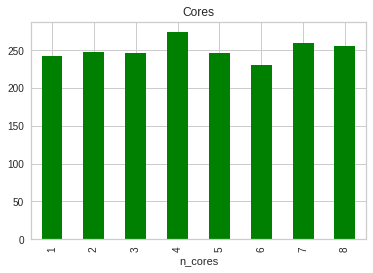

In [8]:
df.groupby('n_cores').size().plot.bar(color='green')
plt.title('Cores');

## Connectivity

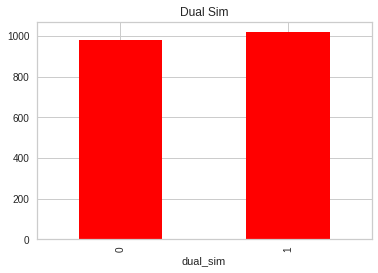

In [9]:
df.groupby('dual_sim').size().plot.bar(color='red');
plt.title('Dual Sim');

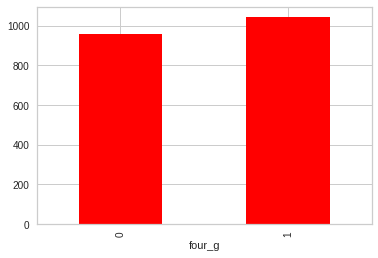

In [10]:
df.groupby('four_g').size().plot.bar(color='red')

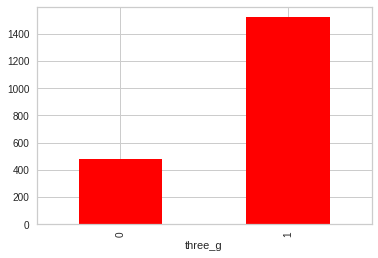

In [11]:
df.groupby('three_g').size().plot.bar(color='red')

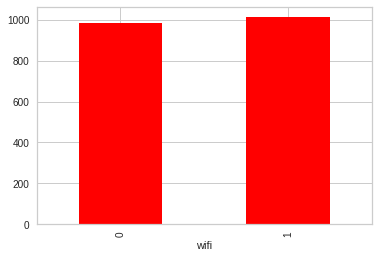

In [12]:
df.groupby('wifi').size().plot.bar(color='red')

## Memory

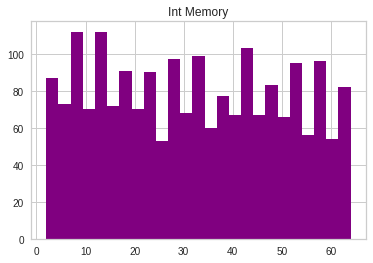

In [13]:
df.int_memory.hist(bins=25, color='purple')
plt.title('Int Memory');

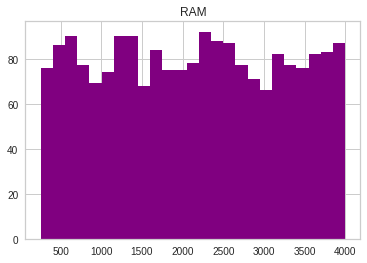

In [14]:
df.ram.hist(bins=25, color='purple')
plt.title('RAM');

## Screen

Text(0.5, 1.0, 'Touch Screen')

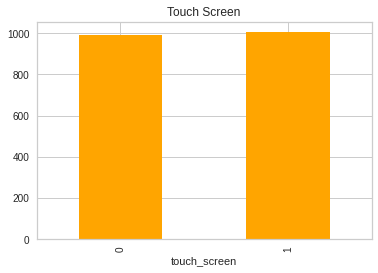

In [15]:
df.groupby('touch_screen').size().plot.bar(color='orange');
plt.title('Touch Screen')

Text(0.5, 1.0, 'Pixels Height vs Width')

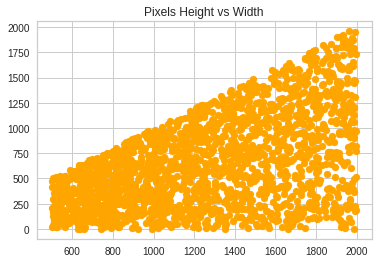

In [16]:
plt.scatter(df.px_width, df.px_height, color='orange')
plt.title('Pixels Height vs Width')

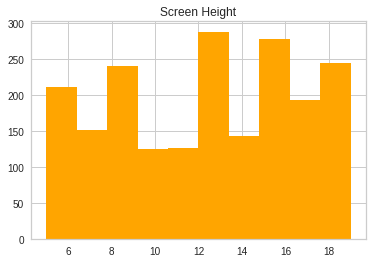

In [17]:
df.sc_h.hist(bins=10, color='orange')
plt.title('Screen Height');

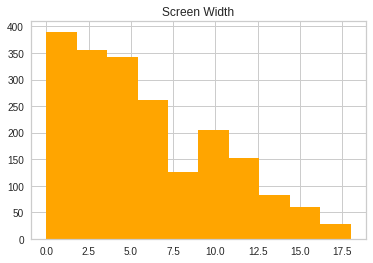

In [18]:
df.sc_w.hist(bins=10, color='orange')
plt.title('Screen Width');

## Misc

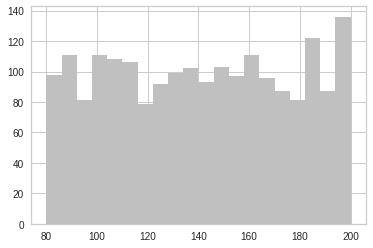

In [19]:
df.mobile_wt.hist(bins=20, color='silver')

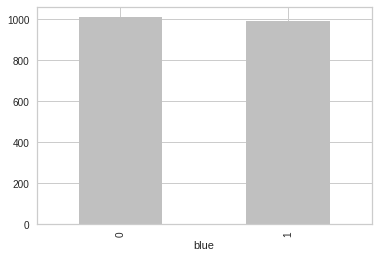

In [20]:
df.groupby('blue').size().plot.bar(color='silver')

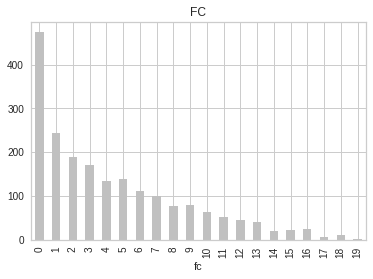

In [21]:
df.groupby('fc').size().plot.bar(color='silver')
plt.title('FC');

# Data Types

# Focus

# XGBoost
![](https://upload.wikimedia.org/wikipedia/commons/6/69/XGBoost_logo.png)

* eXtreme Gradient Boosting
* Became the top kaggle algorithm for structured data
* Features
  * Regularization to avoid overfitting
  * Built in cross-validation
  * Parallel building
  * Customized loss functions
  * Automatic handling of missing data
* Variety of Problems
  * Classification
  * Regression
  * Ranking

## Loss Function + Regularization

![](https://miro.medium.com/max/1280/1*KYsee4_f3y7aJJiuE4JAEg.png)

![](https://raw.githubusercontent.com/dmlc/web-data/master/xgboost/model/step_fit.png)

## Tree Complexity
* Max Depth to control complexity
* Trees typically built level-wise
* Practical Advice
 * Usually start at 6
 * Good parameter to hypertune
 * Some tasks perform better with shallower trees (2 - 4)
 * Have heard of using very large depth trees (30+)

![](https://bradleyboehmke.github.io/random-forest-training/slides-source_files/figure-html/maxdepth-1.gif)

## Histogram Tree Building
* Finding the optimal split is time conumsing
 * Proportional to number of splits
 * But, small changes in split don't make big changes in performance
* Split features into bins & check splits on bins
* Tradeoff
 * Small number of bins = Faster, Less Accurate
 * Large number of bins (@ limit = bin per split) = Slower, More Accurate
* Finding the correct binning
 * Trivial binning (equal interval) will often be unbalanced
 * Exact : identify best split
 * Approx : tree-method will compute new bins on each split
 * Hist : tree-method will compute bins once & reuse 
 * Auto : Depends on dagtaset
   * Small -> Exact
   * Large -> Approx
* Hist building reduces BigO

## Gradient

![](https://media.geeksforgeeks.org/wp-content/uploads/20200721214745/gradientboosting.PNG)

## Learning Rate
* Large learning rates
 * 1.0 considered large / full step on gradient
 * Faster convergence
 * Overshoot or miss minima
* Smaller learning rate
 * Slower to converge
 * More likely to find good minima
 * Advice - smallest learning rate you can tolerate

## Missing Data
* Missing data doesn't need to be imputed with XGBoost
* It can build tree splits for missing
* Set value to None or a sentinal

# Initialize

## Categorical
* We'll do a simple label encoding
* Can you get better performance with one-hot?

In [22]:
CATEGORIES = ['blue', 'dual_sim', 'fc', 'four_g', 'pc', 'three_g', 'touch_screen', 'wifi']
for cat in CATEGORIES:
  df[cat] = df[cat].astype('int')

## Split

In [23]:
y = df['price_range']
y = y.astype('category')
X = df.copy().drop(columns=['price_range'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=400, random_state=1)

## Results

In [24]:
results_df = pd.DataFrame(columns=['Trees', 'Accuracy'])

# First Model
* 500 estimators
* Use XGBoost defaults

## Fit

In [25]:
model = xgb.XGBClassifier(n_estimators=500)
results = model.fit(X_train, y_train)

## Test

In [26]:
preds = model.predict(X_test)
score = accuracy_score(y_test, preds)
results_df.loc['Baseline'] = [model.n_estimators, score]
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95        92
           1       0.84      0.90      0.87        96
           2       0.86      0.86      0.86       106
           3       0.95      0.92      0.94       106

    accuracy                           0.90       400
   macro avg       0.90      0.90      0.90       400
weighted avg       0.90      0.90      0.90       400



# Early Stopping - Take 1
* Split our training set into train and evaluation
* Learn from train, and stop when our progress on the evaluation set flatlines
* Use multi-class error for our evaluation set metric

## Eval Set

In [27]:
X_train_es, X_eval_es, y_train_es, y_eval_es = train_test_split(X_train, y_train, random_state=12)

## Fit

In [28]:
model = xgb.XGBClassifier(n_estimators=500, learning_rate=0.1)
results = model.fit(X_train_es, y_train_es, 
                    eval_set=[(X_eval_es, y_eval_es)], 
                    eval_metric=['merror'],
                    early_stopping_rounds=10)
results

[0]	validation_0-merror:0.2325
Will train until validation_0-merror hasn't improved in 10 rounds.
[1]	validation_0-merror:0.22
[2]	validation_0-merror:0.2225
[3]	validation_0-merror:0.2225
[4]	validation_0-merror:0.2125
[5]	validation_0-merror:0.205
[6]	validation_0-merror:0.205
[7]	validation_0-merror:0.2025
[8]	validation_0-merror:0.1975
[9]	validation_0-merror:0.1825
[10]	validation_0-merror:0.1825
[11]	validation_0-merror:0.1775
[12]	validation_0-merror:0.175
[13]	validation_0-merror:0.175
[14]	validation_0-merror:0.1775
[15]	validation_0-merror:0.1675
[16]	validation_0-merror:0.165
[17]	validation_0-merror:0.17
[18]	validation_0-merror:0.17
[19]	validation_0-merror:0.1675
[20]	validation_0-merror:0.17
[21]	validation_0-merror:0.1725
[22]	validation_0-merror:0.175
[23]	validation_0-merror:0.175
[24]	validation_0-merror:0.17
[25]	validation_0-merror:0.17
[26]	validation_0-merror:0.17
Stopping. Best iteration:
[16]	validation_0-merror:0.165



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

## Test
* Model fit to 500 estimators did a lot better than early stopping
* What happened?

In [29]:
preds = model.predict(X_test)
score = accuracy_score(y_test, preds)
results_df.loc['Early Stopping - Take 1'] = [model.best_iteration, score]
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.90      0.91      0.91        92
           1       0.72      0.77      0.74        96
           2       0.67      0.65      0.66       106
           3       0.84      0.80      0.82       106

    accuracy                           0.78       400
   macro avg       0.78      0.78      0.78       400
weighted avg       0.78      0.78      0.78       400



# Early Stopping - Take 2
* merror (multiclass error) wasn't a good eval metric for early stop
* Better option here is mlogloss (multiclass log loss)
* LogLoss is related back to cross-entropy
* Takes into account how confident we are of a prediction

## Eval Set

In [30]:
X_train_es, X_eval_es, y_train_es, y_eval_es = train_test_split(X_train, y_train, random_state=12)

## Fit

In [31]:
model = xgb.XGBClassifier(n_estimators=500, learning_rate=0.1)
results = model.fit(X_train_es, y_train_es, 
                    eval_set=[(X_eval_es, y_eval_es)], 
                    eval_metric=['mlogloss'],
                    early_stopping_rounds=10)
results

[0]	validation_0-mlogloss:1.27551
Will train until validation_0-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:1.18383
[2]	validation_0-mlogloss:1.10475
[3]	validation_0-mlogloss:1.03823
[4]	validation_0-mlogloss:0.979904
[5]	validation_0-mlogloss:0.929662
[6]	validation_0-mlogloss:0.881392
[7]	validation_0-mlogloss:0.839679
[8]	validation_0-mlogloss:0.801386
[9]	validation_0-mlogloss:0.768716
[10]	validation_0-mlogloss:0.73744
[11]	validation_0-mlogloss:0.709899
[12]	validation_0-mlogloss:0.684224
[13]	validation_0-mlogloss:0.661716
[14]	validation_0-mlogloss:0.640849
[15]	validation_0-mlogloss:0.622598
[16]	validation_0-mlogloss:0.606838
[17]	validation_0-mlogloss:0.589526
[18]	validation_0-mlogloss:0.575552
[19]	validation_0-mlogloss:0.562011
[20]	validation_0-mlogloss:0.549368
[21]	validation_0-mlogloss:0.538077
[22]	validation_0-mlogloss:0.526502
[23]	validation_0-mlogloss:0.515418
[24]	validation_0-mlogloss:0.5068
[25]	validation_0-mlogloss:0.497095
[26]	validat

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

## Test

In [32]:
preds = model.predict(X_test)
score = accuracy_score(y_test, preds)
results_df.loc['Early Stopping - Take 2'] = [model.best_iteration, score]
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92        92
           1       0.81      0.86      0.84        96
           2       0.85      0.86      0.85       106
           3       0.96      0.92      0.94       106

    accuracy                           0.89       400
   macro avg       0.89      0.89      0.89       400
weighted avg       0.89      0.89      0.89       400



# Early Stopping - Take 3
* Having proven out that we can early stop and get good results
* We drop the learning rate and increase the number of iterations

## Eval Set

In [33]:
X_train_es, X_eval_es, y_train_es, y_eval_es = train_test_split(X_train, y_train, random_state=12)

## Fit

In [34]:
model = xgb.XGBClassifier(n_estimators=5000, learning_rate=0.01)
results = model.fit(X_train_es, y_train_es, 
                    eval_set=[(X_eval_es, y_eval_es)], 
                    eval_metric=['mlogloss'],
                    early_stopping_rounds=10)
results

[0]	validation_0-mlogloss:1.37487
Will train until validation_0-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:1.36364
[2]	validation_0-mlogloss:1.35261
[3]	validation_0-mlogloss:1.3418
[4]	validation_0-mlogloss:1.33115
[5]	validation_0-mlogloss:1.32074
[6]	validation_0-mlogloss:1.3104
[7]	validation_0-mlogloss:1.30029
[8]	validation_0-mlogloss:1.29036
[9]	validation_0-mlogloss:1.28065
[10]	validation_0-mlogloss:1.2711
[11]	validation_0-mlogloss:1.26174
[12]	validation_0-mlogloss:1.25248
[13]	validation_0-mlogloss:1.24343
[14]	validation_0-mlogloss:1.23447
[15]	validation_0-mlogloss:1.22559
[16]	validation_0-mlogloss:1.21683
[17]	validation_0-mlogloss:1.20814
[18]	validation_0-mlogloss:1.1996
[19]	validation_0-mlogloss:1.19135
[20]	validation_0-mlogloss:1.18306
[21]	validation_0-mlogloss:1.17493
[22]	validation_0-mlogloss:1.16702
[23]	validation_0-mlogloss:1.15921
[24]	validation_0-mlogloss:1.15147
[25]	validation_0-mlogloss:1.14394
[26]	validation_0-mlogloss:1.13642


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=5000, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

## Test

In [35]:
preds = model.predict(X_test)
score = accuracy_score(y_test, preds)
results_df.loc['Early Stopping - Take 3'] = [model.best_iteration, score]
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92        92
           1       0.81      0.86      0.84        96
           2       0.84      0.85      0.85       106
           3       0.95      0.91      0.93       106

    accuracy                           0.88       400
   macro avg       0.88      0.88      0.88       400
weighted avg       0.88      0.88      0.88       400



# Results
* Why did early stopping underperform?

In [36]:
results_df

,Trees,Accuracy
Baseline,500.0,0.9025
Early Stopping - Take 1,16.0,0.7800
Early Stopping - Take 2,280.0,0.8875
Early Stopping - Take 3,2745.0,0.8825


# Learning Rates
* Construct a model, using defaults and 1000 estimators
* Evaluate training, validation and test
* Plot results (What do you see?)

In [37]:
model_lr = xgb.XGBClassifier(n_estimators=1000, learning_rate=0.1)
results = model_lr.fit(X_train_es, y_train_es, 
                    eval_set=[(X_train_es, y_train_es), (X_eval_es, y_eval_es), (X_test, y_test)], 
                    eval_metric=['mlogloss'])

[0]	validation_0-mlogloss:1.2688	validation_1-mlogloss:1.27551	validation_2-mlogloss:1.28166
[1]	validation_0-mlogloss:1.17098	validation_1-mlogloss:1.18383	validation_2-mlogloss:1.19381
[2]	validation_0-mlogloss:1.08708	validation_1-mlogloss:1.10475	validation_2-mlogloss:1.11891
[3]	validation_0-mlogloss:1.01581	validation_1-mlogloss:1.03823	validation_2-mlogloss:1.05651
[4]	validation_0-mlogloss:0.952913	validation_1-mlogloss:0.979904	validation_2-mlogloss:1.00192
[5]	validation_0-mlogloss:0.898357	validation_1-mlogloss:0.929662	validation_2-mlogloss:0.955569
[6]	validation_0-mlogloss:0.8493	validation_1-mlogloss:0.881392	validation_2-mlogloss:0.912367
[7]	validation_0-mlogloss:0.806309	validation_1-mlogloss:0.839679	validation_2-mlogloss:0.876988
[8]	validation_0-mlogloss:0.766993	validation_1-mlogloss:0.801386	validation_2-mlogloss:0.840911
[9]	validation_0-mlogloss:0.732144	validation_1-mlogloss:0.768716	validation_2-mlogloss:0.81174
[10]	validation_0-mlogloss:0.698931	validation_

In [38]:
results = model_lr.evals_result()
learning_df = pd.DataFrame(columns=['Iteration', 'Train', 'Validation', 'Test'])
learning_df['Iteration']  = np.arange(1, model_lr.n_estimators + 1)
learning_df['Train']      = results['validation_0']['mlogloss']
learning_df['Validation'] = results['validation_1']['mlogloss']
learning_df['Test']       = results['validation_2']['mlogloss']
learning_df.head()

,Iteration,Train,Validation,Test
0,1,1.268796,1.275512,1.281659
1,2,1.170983,1.183831,1.193810
2,3,1.087080,1.104746,1.118910
3,4,1.015811,1.038230,1.056508
4,5,0.952913,0.979904,1.001922


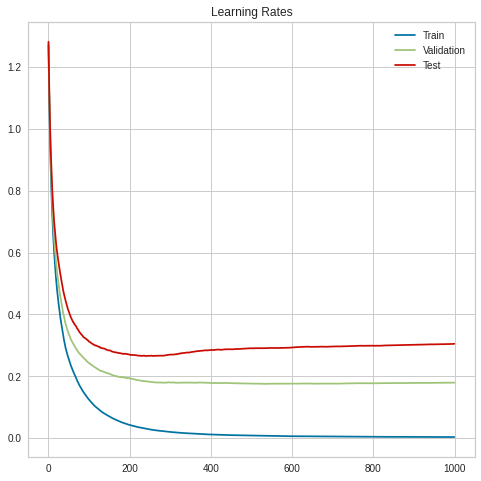

In [39]:
learning_df[['Train', 'Validation', 'Test']].plot(figsize=(8, 8))
plt.title('Learning Rates');

# Basic Error Analysis
* Assemble test data for review and error analysis

## Predicted Class

In [40]:
pred_df = X_test.copy()
preds = model.predict(pred_df)
pred_df['Prediction'] = preds
pred_df['Actual'] = y_test
pred_df

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,Prediction,Actual
674,1034,0,2.6,1,2,1,45,0.3,190,3,4,182,1293,969,15,1,7,1,0,0,0,0
1699,1002,1,1.8,0,1,0,45,0.7,180,7,7,948,1007,1234,19,13,18,1,1,0,0,0
1282,609,1,0.5,0,4,1,10,0.1,81,6,6,113,1524,1905,16,3,18,1,1,1,1,1
1315,1510,0,0.6,1,1,0,32,0.7,135,3,8,963,1520,854,8,2,10,1,0,1,1,1
1210,805,1,1.7,1,0,1,58,0.9,168,3,10,81,1544,3397,7,6,2,1,0,0,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,1266,0,1.9,1,0,1,7,0.2,184,3,12,346,1468,2532,10,5,4,1,1,1,2,2
763,1741,1,1.8,0,0,0,14,0.7,143,8,0,730,1895,3387,11,3,3,1,0,0,3,3
385,1880,1,1.8,0,4,1,18,0.7,138,3,5,71,699,3333,17,15,7,1,0,0,3,3
1667,1967,0,0.5,0,0,1,46,0.6,199,1,7,518,1374,1567,15,2,7,1,1,0,1,1


## Probability of Class

In [41]:
pred_df = X_test.copy()
pred  = model.predict(pred_df)
preds = model.predict_proba(pred_df)
preds

array([[9.9946111e-01, 5.3829589e-04, 3.4832902e-07, 2.8765567e-07],
       [9.8718166e-01, 1.2795124e-02, 1.6086642e-05, 7.1553623e-06],
       [8.2861511e-03, 9.8805106e-01, 3.6216879e-03, 4.1102667e-05],
       ...,
       [1.8126852e-05, 2.8775323e-05, 1.7897269e-02, 9.8205584e-01],
       [3.3949726e-04, 9.4581723e-01, 5.2749746e-02, 1.0934959e-03],
       [9.9354869e-01, 6.4429832e-03, 4.0428117e-06, 4.2931633e-06]],
      dtype=float32)

In [42]:
pred_df['Predicted'] = pred
pred_df['Actual']    = y_test

In [43]:
probs_df = pd.DataFrame(preds, columns=['p_class_0', 'p_class_1', 'p_class_2', 'p_class_3'])
probs_df = pd.concat([pred_df.reset_index(drop=True), probs_df], axis=1)
probs_df['Direction'] = probs_df.Predicted - probs_df.Actual.cat.codes
probs_df[probs_df.Predicted != probs_df.Actual]

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,Predicted,Actual,p_class_0,p_class_1,p_class_2,p_class_3,Direction
4,805,1,1.7,1,0,1,58,0.9,168,3,10,81,1544,3397,7,6,2,1,0,0,3,2,0.000685,0.000787,0.056543,0.941984,1
5,1561,0,0.5,1,10,1,4,0.5,134,2,13,885,1811,1783,13,12,10,1,1,0,1,2,0.000105,0.763878,0.234190,0.001827,-1
6,557,1,1.6,0,0,0,24,0.5,125,3,0,1131,1315,1305,12,8,3,1,0,1,1,0,0.417540,0.582001,0.000312,0.000146,1
19,520,0,2.3,0,0,1,31,0.8,145,6,14,264,519,2753,13,7,17,1,0,1,2,1,0.009803,0.300996,0.689082,0.000119,1
38,981,1,1.9,1,0,0,2,0.1,136,3,7,75,688,1539,19,12,19,0,0,0,1,0,0.270356,0.729580,0.000056,0.000008,1
39,1065,0,2.8,1,0,1,21,0.1,158,5,3,760,1722,1193,16,13,20,1,0,1,0,1,0.903855,0.094940,0.000516,0.000689,-1
40,1266,0,0.5,0,0,1,5,0.1,95,6,9,1365,1698,1687,11,0,18,1,0,0,1,2,0.000738,0.701338,0.295321,0.002604,-1
41,1839,1,1.2,0,9,1,54,0.5,200,7,11,475,1493,927,19,10,18,1,0,1,0,1,0.757799,0.235987,0.002030,0.004184,-1
50,1329,1,1.7,0,5,1,23,0.6,198,8,6,380,682,2308,11,10,9,1,1,0,2,1,0.000721,0.309889,0.689243,0.000148,1
54,986,1,1.5,0,1,1,23,0.8,183,8,3,471,800,2385,16,9,19,1,0,0,2,1,0.002358,0.345606,0.651939,0.000096,1


# Feature Importance

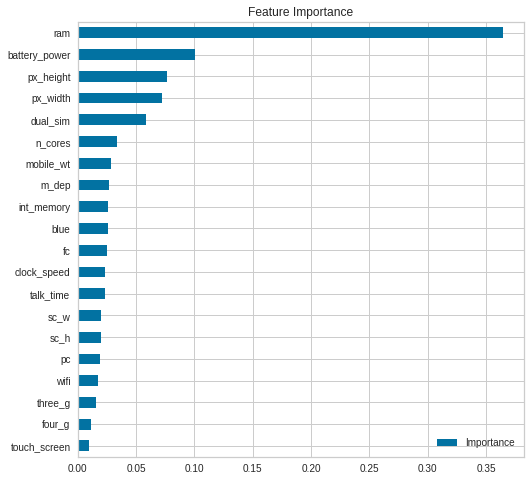

In [44]:
importance = {i[0]: i[1] for i in zip(X_test.columns, model.feature_importances_)}
imp_df = pd.DataFrame([importance]).T
imp_df.columns = ['Importance']
imp_df.sort_values('Importance').plot.barh(figsize=(8,8))
plt.title('Feature Importance');

# Context

![](https://miro.medium.com/max/1850/1*QJZ6W-Pck_W7RlIDwUIN9Q.jpeg)